In [8]:
!pip install cufflinks #connects the Pandas data frame with Plotly

  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68729 sha256=6aa7d464d5c8781eb86a533e1950fcc7f9ec171f5906739403e8b13ab732fffb
  Stored in directory: c:\users\deepak\appdata\local\pip\cache\wheels\6b\76\62\6da97734911ffcbdd559fd1a3f28526321f0ae699182a23866
Successfully built cufflinks


In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deepak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [3]:
#Loading the dataset
df = pd.read_csv('D:\\RecogX_Backup\\EL\\DeepLearning\\consumer_complaints.csv')
#Dropping the NULL values from Consumer complaint narrartive
df = df[pd.notnull(df['Consumer complaint narrative'])]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning:

Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
df['Product'].unique()

array(['Debt collection', 'Consumer Loan', 'Mortgage', 'Credit card',
       'Credit reporting', 'Student loan', 'Bank account or service',
       'Payday loan', 'Money transfers', 'Other financial service',
       'Prepaid card'], dtype=object)

In [5]:
#Frequency table of Product

df['Product'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: Product, dtype: int64

In [6]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'


In [7]:
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'


In [8]:
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'


In [9]:
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [10]:
df[df['Product'] != 'Other financial service']

,date_received,Product,sub_product,issue,sub_issue,Consumer complaint narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
190126,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
190135,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
190207,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553084,02-10-2016,"Credit reporting, credit repair services, or o...",NaN,Incorrect information on credit report,Account status,"XXXX XXXX is reporting incorrectly, payments h...",Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",WA,980XX,NaN,Consent provided,Web,02-10-2016,Closed with explanation,Yes,No,1782682
553085,02-10-2016,"Credit reporting, credit repair services, or o...",NaN,Incorrect information on credit report,Account status,Reflecting incorrect payment status. Have been...,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",WA,980XX,NaN,Consent provided,Web,02-10-2016,Closed with explanation,Yes,No,1781861
553086,02-11-2016,"Payday loan, title loan, or personal loan",Payday loan,Charged fees or interest I didn't expect,Charged fees or interest I didn't expect,I have been paying {$180.00} a month through d...,NaN,Zarvad III S.A.,NV,891XX,Servicemember,Consent provided,Web,02-11-2016,Closed with explanation,Yes,No,1782804
553090,03/30/2016,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,I recently became aware that Amerisave Mortgag...,Company believes it acted appropriately as aut...,Amerisave,AZ,853XX,NaN,Consent provided,Web,03/30/2016,Closed with explanation,Yes,Yes,1855199


In [11]:
#Ploting the Number of Complaints
df['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
                                                                title='Number complaints in each product')

In [12]:
#Data Cleaning like removing special character, punctuation
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


In [13]:
df

,date_received,Product,sub_product,issue,sub_issue,Consumer complaint narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
1,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
2,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
3,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
4,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66801,02-10-2016,"Credit reporting, credit repair services, or o...",NaN,Incorrect information on credit report,Account status,"XXXX XXXX is reporting incorrectly, payments h...",Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",WA,980XX,NaN,Consent provided,Web,02-10-2016,Closed with explanation,Yes,No,1782682
66802,02-10-2016,"Credit reporting, credit repair services, or o...",NaN,Incorrect information on credit report,Account status,Reflecting incorrect payment status. Have been...,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",WA,980XX,NaN,Consent provided,Web,02-10-2016,Closed with explanation,Yes,No,1781861
66803,02-11-2016,"Payday loan, title loan, or personal loan",Payday loan,Charged fees or interest I didn't expect,Charged fees or interest I didn't expect,I have been paying {$180.00} a month through d...,NaN,Zarvad III S.A.,NV,891XX,Servicemember,Consent provided,Web,02-11-2016,Closed with explanation,Yes,No,1782804
66804,03/30/2016,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,I recently became aware that Amerisave Mortgag...,Company believes it acted appropriately as aut...,Amerisave,AZ,853XX,NaN,Consent provided,Web,03/30/2016,Closed with explanation,Yes,Yes,1855199


In [14]:
#Clean data in complain section
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

In [15]:
def print_plot(index):
    example = df[df.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [16]:
print_plot(100)

contacted drivetime several different occasions regarding car loan account # number loan removed also credit bureau positive credit rating closed paid full company insisted avoiding agreement entered company representative corporate position agreed upon resolution provide agency copy capability computer drivetime month removed credit reporting information credit bureaus reporting agencies believe discovered positive credit ratings longer credit bureaus another positive account another car loan longer reporting credit file removals adversely affected credit ratings ability purchase something lower interest rate never missed payment drivetime company car loans inclusive different auto loans destroy credit ratings despicable spoke today regarding issues response drivetime process updating consumers credit files consumers credit files removed credit bureaus updated however know process performed records updated corrected process timeframes process take furthermore process involves consumer

In [17]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 60482 unique tokens.


In [18]:
#Transforms each text in texts to a sequence of integers.
#Uses Keras 
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (66806, 250)


In [19]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (66806, 11)


In [20]:
df['Product'].unique()

array(['Debt collection', 'Consumer Loan', 'Mortgage',
       'Credit card or prepaid card',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Student loan', 'Bank account or service',
       'Payday loan, title loan, or personal loan', 'Money transfers',
       'Other financial service', 'Prepaid card'], dtype=object)

In [21]:
df.loc[df['Product'] == 'Debt collection', 'Product']

0        Debt collection
13       Debt collection
14       Debt collection
15       Debt collection
16       Debt collection
              ...       
66787    Debt collection
66790    Debt collection
66791    Debt collection
66798    Debt collection
66800    Debt collection
Name: Product, Length: 17552, dtype: object

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(60125, 250) (60125, 11)
(6681, 250) (6681, 11)


In [23]:
X_test[0],Y_test[0]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [24]:
model = Sequential()
#Embedding is always be the first layer
#Generate weights
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2)) # it removes all the pixel in a row from all channels
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) #LSTM layer applied
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#Logarithmic loss (related to cross-entropy) measures the performance of a classification model where the prediction 
#input is a probability value between 0 and 1. The goal of our machine learning models is to minimize this value. 
#A perfect model would have a log loss of 0
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 11)                1111      
Total params: 5,081,511
Trainable params: 5,081,511
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
846/846 [==============================] - 381s 450ms/step - loss: 1.2372 - accuracy: 0.6020 - val_loss: 0.9280 - val_accuracy: 0.7269
Epoch 2/5
846/846 [==============================] - 413s 489ms/step - loss: 0.8943 - accuracy: 0.7301 - val_loss: 0.8241 - val_accuracy: 0.7449
Epoch 3/5
846/846 [==============================] - 478s 565ms/step - loss: 0.6891 - accuracy: 0.7910 - val_loss: 0.6599 - val_accuracy: 0.7981
Epoch 4/5
846/846 [==============================] - 480s 567ms/step - loss: 0.5845 - accuracy: 0.8258 - val_loss: 0.6128 - val_accuracy: 0.8176
Epoch 5/5
846/846 [==============================] - 496s 586ms/step - loss: 0.4677 - accuracy: 0.8625 - val_loss: 0.5839 - val_accuracy: 0.8287


In [26]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

209/209 [==============================] - 8s 38ms/step - loss: 0.6196 - accuracy: 0.8180
Test set
  Loss: 0.620
  Accuracy: 0.818


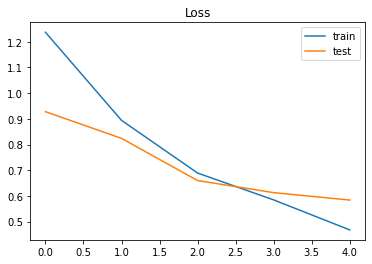

In [27]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

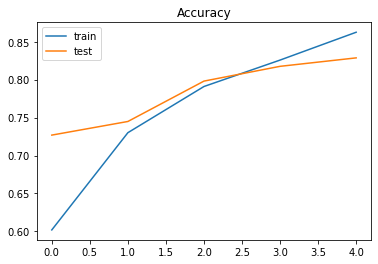

In [28]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [41]:
new_complaint = ['Please let me know the proces of opening bank account']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)


In [42]:
labels = ['Bank account or service', 'Consumer Loan', 'Credit card or prepaid card', 'Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Money transfers', 'Mortgage', 'Other financial service', 'Payday loan, title loan, or personal loan', 'Prepaid card', 'Student loan']
print(pred, labels[np.argmax(pred)])

[[0.9146135  0.00355629 0.0235159  0.00328663 0.00804047 0.01991654
  0.01213998 0.00355954 0.00287214 0.0074537  0.00104538]] Bank account or service
